In [74]:
import mwdsbe
import pandas as pd
import numpy as np
import geopandas as gpd
from matplotlib import pyplot as plt
import seaborn as sns
import schuylkill as skool
import time

In [75]:
registry = mwdsbe.load_registry() # geopandas df

In [76]:
registry.head()

,company_name,dba_name,owner_first,owner_last,location,location_city,location_state,zip_code,mailing_address,mailing_city,...,mailing_zip,certification_type,capability,local,out_of_state,location_standard,lat,lng,geometry,in_philly_msa
registry_id,,,,,,,,,,,,,,,,,,,,,
0,119 Degrees Architects,NaN,Rafael,Utrera,"1503 Green Street, Suite # 4",Philadelphia,PA,19130.0,"1503 Green Street, Suite # 4",Philadelphia,...,19130.0,MBE,"NAICS 5413 Architectural, Engineering, and Rel...",True,False,1503 GREEN ST,39.964275,-75.163042,POINT (-75.16304 39.96427),True
1,12Bravo Group,NaN,JEFFREY,YEKENCHIK,236 McKendimen Road,Medford Lakes,NJ,8055.0,236 McKendimen Road,Medford Lakes,...,8055.0,DSBE,"Addition, alteration and renovation for-sale b...",False,True,NaN,39.858549,-74.795140,POINT (-74.79514 39.85855),True
2,1st Choice Financial Group,ProVisio,Kathrina,Nease,133 N. 21st Street,Camp Hill,PA,17011.0,133 N. 21st Street,Camp Hill,...,17011.0,WBE,NAICS 928120 International Affairs,False,False,NaN,40.242642,-76.920564,POINT (-76.92056 40.24264),False
3,212 Harakawa Inc.,Two Twelve,Ann,Harakawa,"236 W 27th Street, Suite 802",New York,NY,10001.0,"236 W 27th Street, Suite 802",New York,...,10001.0,MWBE,Graphic Design Services; Graphic design servic...,False,True,NaN,40.747390,-73.995685,POINT (-73.99568 40.74739),False
4,215 Media Solutions,NaN,Dewain,Johnson,810 Felton Avenue,Sharon Hill,PA,19079.0,810 Felton Avenue,Sharon Hill,...,19079.0,MBE,NAICS 5414 Specialized Design Services ; NAICS...,False,False,NaN,39.899658,-75.269865,POINT (-75.26986 39.89966),True


In [77]:
registry_geo = registry.dropna(subset=['geometry'])

In [78]:
len(registry_geo)

3115

In [79]:
# get only Philly MSA
phillyMSA = registry_geo.loc[registry_geo.in_philly_msa == True]

In [80]:
len(phillyMSA)

1883

In [81]:
# export philly MSA companies as json for map
with open("company.json", "w") as ff:
        ff.write(phillyMSA.to_json())

In [12]:
# in city
in_city = phillyMSA.loc[phillyMSA.local == True]

In [13]:
len(in_city)

912

## Matching
Fuzz95 + TFIDF80

In [14]:
gf = pd.read_excel(r'C:\Users\dabinlee\Documents\GitHub\mwdsbe_binny\MWDSBE\mwdsbe\data\cwedp_37_report.xlsx', sheet_name='general_funds')

In [15]:
# filter gf with unrevelant maj_class and na vendor name
gf = gf.loc[gf['MAJ_CLASS'] != 1]
gf = gf.loc[gf['VEND_NAME'].dropna().index]
len(gf)

243375

In [17]:
# clean data
ignore_words = ['inc', 'group', 'llc', 'corp', 'pc', 'incorporated', 'ltd', 'co', 'associates', 'services', 'company', 'enterprises', 'enterprise', 'service', 'corporation']
cleaned_registry = skool.clean_strings(registry, ['company_name', 'dba_name'], True, ignore_words)
cleaned_gf = skool.clean_strings(gf, ['VEND_NAME'], True, ignore_words)

cleaned_registry = cleaned_registry.dropna(subset=['company_name'])
cleaned_gf = cleaned_gf.dropna(subset=['VEND_NAME'])

In [18]:
t1 = time.time()
merged = (
    skool.fuzzy_merge(cleaned_registry, cleaned_gf, left_on="company_name", right_on="VEND_NAME", score_cutoff=95)
    .pipe(skool.fuzzy_merge, cleaned_registry, cleaned_gf, left_on="dba_name", right_on="VEND_NAME", score_cutoff=95)
    .pipe(skool.tf_idf_merge, cleaned_registry, cleaned_gf, left_on="company_name", right_on="VEND_NAME", score_cutoff=80)
    .pipe(skool.tf_idf_merge, cleaned_registry, cleaned_gf, left_on="dba_name", right_on="VEND_NAME", score_cutoff=80)
)
t = time.time() - t1

In [19]:
print('Execution time:', t/60, 'min')

Execution time: 21.788003881772358 min


In [20]:
matched = merged.dropna(subset=['VEND_NAME'])

In [21]:
len(matched)

150

In [39]:
# Manually remove 14 wrong matches
wrong_matches = ['a g consulting engineering', 'amercom consulting engineers', 'awk consulting engineers', 
                 'briones consulting engineering', 'dy consulting engineer p c', 'environmental management',
                 'events unlimited', 'hill environmental', 'kma consulting engineers', 'milligan and', 
                 'ms technologies', 'specialists', 'site contractors', 'stell environmental']
matches = matched.loc[matched['company_name'].apply(lambda x : x not in wrong_matches)]
len(matches)

136

In [40]:
matches.head()

,company_name,dba_name,owner_first,owner_last,location,location_city,location_state,zip_code,mailing_address,mailing_city,...,MAJ_CLASS,CLASS,DOC_NUM,TRANS_DESC,DOC_REF_NUM,VEND_NAME,VEND_NUM,AMT,DOC_NUM4,DOC_REF4
12,4u,stellar,Liang,Chen,"70 West 36th Street, Ste. #702",New York,NY,10018.0,"70 West 36th Street, Ste. #702",New York,...,2.0,0250,PVMD1902159601,*1669* MAY19 DAO,MDXX1900001301,4u,113189413 02,7420.00,PVMD,MDXX
18,a a court reporting,andrea st john,Andrea,St. John,"303 Chestnut Street, Second Floor",Philadelphia,PA,19106.0,"P.O. Box 74, Suite 4",Moorestown,...,2.0,0258,PVXX1901098501,*35987* APR19 JAMES MCINTYRE V. CITY,NaN,a a court reporting,233034758 02,350.05,PVXX,NaN
19,a a glove safety,NaN,Ana M,Fisher,20 Richey Avenue,Collingswood,NJ,8107.0,20 Richey Avenue,Collingswood,...,3.0,0316,VCXX1903158301,*74033* ELEC CHAIN HOIST AUG18,POXX1910343701,a a glove safety,223525598 01,2254.00,VCXX,POXX
60,acacia financial,NaN,Noreen,White,"6000 Midlantic Drive, Suite 410 North",Mt. Laurel,NJ,8054.0,"6000 Midlantic Drive, Suite 410 North",Mt. Laurel,...,7.0,0705,PVXX1901010901,*09B EXTENSION* FA FEES,NaN,acacia financial,204775407 01,3000.00,PVXX,NaN
65,acclaim systems,NaN,Kailash,Kalantri,110 EAST PENNSYLVANIA BOULEVARD,Feasterville,PA,19053.0,110 EAST PENNSYLVANIA BOULEVARD,Feasterville,...,2.0,0251,PVMD1901613001,*PHL13* PLIS SUPPT/MAINT 4/2018-3/2019 MAR19,MDXX1800135401,acclaim systems,364182176 02,91393.34,PVMD,MDXX


In [41]:
matches.columns

Index(['company_name', 'dba_name', 'owner_first', 'owner_last', 'location',
       'location_city', 'location_state', 'zip_code', 'mailing_address',
       'mailing_city', 'mailing_state', 'mailing_zip', 'certification_type',
       'capability', 'local', 'out_of_state', 'location_standard', 'lat',
       'lng', 'geometry', 'in_philly_msa', 'match_probability', 'right_index',
       'DR_ACCT', 'CR_ACCT', 'CURR_PRIOR_FLAG', 'POSTED_DATE', 'DEPT',
       'SEC_FD', 'INDEX', 'PROGRAM_CD', 'MAJ_CLASS', 'CLASS', 'DOC_NUM',
       'TRANS_DESC', 'DOC_REF_NUM', 'VEND_NAME', 'VEND_NUM', 'AMT', 'DOC_NUM4',
       'DOC_REF4'],
      dtype='object')

In [43]:
# in Philly MSA
after_phillyMSA = matches.loc[matches.in_philly_msa == True]

In [44]:
len(after_phillyMSA)

101

In [45]:
# in city
after_incity = after_phillyMSA.loc[after_phillyMSA.local == True]

In [46]:
len(after_incity)

55

In [47]:
unique_vendors = matches['VEND_NAME'].tolist()

In [48]:
full_matches = cleaned_gf.loc[cleaned_gf['VEND_NAME'].apply(lambda x : x in unique_vendors)]

In [49]:
len(full_matches)

5661

In [58]:
full_data = matches.merge(full_matches, on='VEND_NAME')

In [60]:
full_data.columns

Index(['company_name', 'dba_name', 'owner_first', 'owner_last', 'location',
       'location_city', 'location_state', 'zip_code', 'mailing_address',
       'mailing_city', 'mailing_state', 'mailing_zip', 'certification_type',
       'capability', 'local', 'out_of_state', 'location_standard', 'lat',
       'lng', 'geometry', 'in_philly_msa', 'match_probability', 'right_index',
       'DR_ACCT_x', 'CR_ACCT_x', 'CURR_PRIOR_FLAG_x', 'POSTED_DATE_x',
       'DEPT_x', 'SEC_FD_x', 'INDEX_x', 'PROGRAM_CD_x', 'MAJ_CLASS_x',
       'CLASS_x', 'DOC_NUM_x', 'TRANS_DESC_x', 'DOC_REF_NUM_x', 'VEND_NAME',
       'VEND_NUM_x', 'AMT_x', 'DOC_NUM4_x', 'DOC_REF4_x', 'DR_ACCT_y',
       'CR_ACCT_y', 'CURR_PRIOR_FLAG_y', 'POSTED_DATE_y', 'DEPT_y', 'SEC_FD_y',
       'INDEX_y', 'PROGRAM_CD_y', 'MAJ_CLASS_y', 'CLASS_y', 'DOC_NUM_y',
       'TRANS_DESC_y', 'DOC_REF_NUM_y', 'VEND_NUM_y', 'AMT_y', 'DOC_NUM4_y',
       'DOC_REF4_y'],
      dtype='object')

In [62]:
payment_inMSA = full_data.loc[full_data.in_philly_msa == True]

In [63]:
len(payment_inMSA)

4636

In [64]:
payment_incity = payment_inMSA.loc[payment_inMSA.local == True]

In [65]:
len(payment_incity)

2720

In [66]:
total_pay = full_data.AMT_y.sum()

In [67]:
total_pay

57195177.41000001

In [68]:
payment_inMSA.AMT_y.sum()

49864323.300000004

In [69]:
payment_incity.AMT_y.sum()

46489313.17

In [70]:
pymet_outcity = payment_inMSA.loc[payment_inMSA.local == False]

In [71]:
pymet_outcity.AMT_y.sum()

3375010.13

## Combine registry, gf, neighborhoods
registry, payment amount, zillow

In [85]:
full_data.groupby('VEND_NAME')['AMT_y'].sum()

VEND_NAME
4u                           178240.00
a a court reporting            5215.00
a a glove safety              45686.49
a v international            742489.00
acacia financial               3000.00
                               ...    
westchester environmental     28206.75
wfgd studio                   41375.00
yikes                         31528.00
zanaras reporting video        4588.10
zones                         14519.39
Name: AMT_y, Length: 135, dtype: float64

In [89]:
matches.head()

,company_name,dba_name,owner_first,owner_last,location,location_city,location_state,zip_code,mailing_address,mailing_city,...,MAJ_CLASS,CLASS,DOC_NUM,TRANS_DESC,DOC_REF_NUM,VEND_NAME,VEND_NUM,AMT,DOC_NUM4,DOC_REF4
12,4u,stellar,Liang,Chen,"70 West 36th Street, Ste. #702",New York,NY,10018.0,"70 West 36th Street, Ste. #702",New York,...,2.0,0250,PVMD1902159601,*1669* MAY19 DAO,MDXX1900001301,4u,113189413 02,7420.00,PVMD,MDXX
18,a a court reporting,andrea st john,Andrea,St. John,"303 Chestnut Street, Second Floor",Philadelphia,PA,19106.0,"P.O. Box 74, Suite 4",Moorestown,...,2.0,0258,PVXX1901098501,*35987* APR19 JAMES MCINTYRE V. CITY,NaN,a a court reporting,233034758 02,350.05,PVXX,NaN
19,a a glove safety,NaN,Ana M,Fisher,20 Richey Avenue,Collingswood,NJ,8107.0,20 Richey Avenue,Collingswood,...,3.0,0316,VCXX1903158301,*74033* ELEC CHAIN HOIST AUG18,POXX1910343701,a a glove safety,223525598 01,2254.00,VCXX,POXX
60,acacia financial,NaN,Noreen,White,"6000 Midlantic Drive, Suite 410 North",Mt. Laurel,NJ,8054.0,"6000 Midlantic Drive, Suite 410 North",Mt. Laurel,...,7.0,0705,PVXX1901010901,*09B EXTENSION* FA FEES,NaN,acacia financial,204775407 01,3000.00,PVXX,NaN
65,acclaim systems,NaN,Kailash,Kalantri,110 EAST PENNSYLVANIA BOULEVARD,Feasterville,PA,19053.0,110 EAST PENNSYLVANIA BOULEVARD,Feasterville,...,2.0,0251,PVMD1901613001,*PHL13* PLIS SUPPT/MAINT 4/2018-3/2019 MAR19,MDXX1800135401,acclaim systems,364182176 02,91393.34,PVMD,MDXX


In [95]:
len(matches)

136

In [91]:
company_names = registry[['company_name']]

In [96]:
data = company_names.merge(matches, left_index=True, right_index=True)

In [97]:
data

,company_name_x,company_name_y,dba_name,owner_first,owner_last,location,location_city,location_state,zip_code,mailing_address,...,MAJ_CLASS,CLASS,DOC_NUM,TRANS_DESC,DOC_REF_NUM,VEND_NAME,VEND_NUM,AMT,DOC_NUM4,DOC_REF4
12,4U Services Inc.,4u,stellar,Liang,Chen,"70 West 36th Street, Ste. #702",New York,NY,10018.0,"70 West 36th Street, Ste. #702",...,2.0,0250,PVMD1902159601,*1669* MAY19 DAO,MDXX1900001301,4u,113189413 02,7420.00,PVMD,MDXX
18,A & A Court Reporting,a a court reporting,andrea st john,Andrea,St. John,"303 Chestnut Street, Second Floor",Philadelphia,PA,19106.0,"P.O. Box 74, Suite 4",...,2.0,0258,PVXX1901098501,*35987* APR19 JAMES MCINTYRE V. CITY,NaN,a a court reporting,233034758 02,350.05,PVXX,NaN
19,A & A Glove & Safety Company,a a glove safety,NaN,Ana M,Fisher,20 Richey Avenue,Collingswood,NJ,8107.0,20 Richey Avenue,...,3.0,0316,VCXX1903158301,*74033* ELEC CHAIN HOIST AUG18,POXX1910343701,a a glove safety,223525598 01,2254.00,VCXX,POXX
60,"Acacia Financial Group, Inc.",acacia financial,NaN,Noreen,White,"6000 Midlantic Drive, Suite 410 North",Mt. Laurel,NJ,8054.0,"6000 Midlantic Drive, Suite 410 North",...,7.0,0705,PVXX1901010901,*09B EXTENSION* FA FEES,NaN,acacia financial,204775407 01,3000.00,PVXX,NaN
65,ACCLAIM SYSTEMS INC,acclaim systems,NaN,Kailash,Kalantri,110 EAST PENNSYLVANIA BOULEVARD,Feasterville,PA,19053.0,110 EAST PENNSYLVANIA BOULEVARD,...,2.0,0251,PVMD1901613001,*PHL13* PLIS SUPPT/MAINT 4/2018-3/2019 MAR19,MDXX1800135401,acclaim systems,364182176 02,91393.34,PVMD,MDXX
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3052,"West Chester Environmental, LLC",west chester environmental,NaN,Matthew,Abraham,1248 Wrights Ln,West Chester,PA,19380.0,1248 Wrights Ln,...,2.0,0250,PVMD1901826802,*5774* 2522 N COLORADO ST APR19,MDXX1800025901,westchester environmental,364510971 01,296.50,PVMD,MDXX
3056,"WFGD Studio, LLC",wfgd studio,NaN,Marcella,Coffey,"718 Arch Street, Suite 302s",Philadelphia,PA,19106.0,"718 Arch Street, Suite 302S",...,2.0,0250,PVMD1900042901,*5765*CONTRACT MPXX18000282 FOR MAY-JUN 2018 SVCS,MPXX1800028201,wfgd studio,454869723 01,8295.00,PVMD,MPXX
3097,"YIKES, Inc.",yikes,NaN,Tracy,Levesque,204 East Girard Avenue,Philadelphia,PA,19125.0,204 East Girard Avenue,...,2.0,0250,PVMD1900395301,*9126* PROF SERVICES RENDERED,MPXX1900018701,yikes,232940295 01,18788.00,PVMD,MPXX
3106,"Zanaras Reporting & Video, LLC",zanaras reporting video,NaN,JULIE,ZANARAS,"1845 WALNUT STREET, Suite 938",Philadelphia,PA,19103.0,"1845 WALNUT STREET, Suite 938",...,2.0,0258,PVXX1900785401,*56215* NOV18 99185 STREETS HINTON V. SEPTA,NaN,zanaras reporting video,510620006 01,231.80,PVXX,NaN


In [103]:
payments = full_matches.groupby('VEND_NAME')['AMT'].sum().to_frame('TOTAL_AMT').reset_index()

In [106]:
combined = data.merge(payments, on='VEND_NAME')

In [107]:
combined.columns

Index(['company_name_x', 'company_name_y', 'dba_name', 'owner_first',
       'owner_last', 'location', 'location_city', 'location_state', 'zip_code',
       'mailing_address', 'mailing_city', 'mailing_state', 'mailing_zip',
       'certification_type', 'capability', 'local', 'out_of_state',
       'location_standard', 'lat', 'lng', 'geometry', 'in_philly_msa',
       'match_probability', 'right_index', 'DR_ACCT', 'CR_ACCT',
       'CURR_PRIOR_FLAG', 'POSTED_DATE', 'DEPT', 'SEC_FD', 'INDEX',
       'PROGRAM_CD', 'MAJ_CLASS', 'CLASS', 'DOC_NUM', 'TRANS_DESC',
       'DOC_REF_NUM', 'VEND_NAME', 'VEND_NUM', 'AMT', 'DOC_NUM4', 'DOC_REF4',
       'TOTAL_AMT'],
      dtype='object')

In [108]:
combined = combined.drop(["right_index", "DR_ACCT", "CR_ACCT", "CURR_PRIOR_FLAG", "SEC_FD", "INDEX", "PROGRAM_CD", "DOC_NUM", "TRANS_DESC", "DOC_REF_NUM", "AMT", "DOC_NUM4", "DOC_REF4"], axis=1)

In [109]:
combined

,company_name_x,company_name_y,dba_name,owner_first,owner_last,location,location_city,location_state,zip_code,mailing_address,...,geometry,in_philly_msa,match_probability,POSTED_DATE,DEPT,MAJ_CLASS,CLASS,VEND_NAME,VEND_NUM,TOTAL_AMT
0,4U Services Inc.,4u,stellar,Liang,Chen,"70 West 36th Street, Ste. #702",New York,NY,10018.0,"70 West 36th Street, Ste. #702",...,POINT (-73.98628 40.75059),False,1.000000,2019-06-25,69.0,2.0,0250,4u,113189413 02,178240.00
1,A & A Court Reporting,a a court reporting,andrea st john,Andrea,St. John,"303 Chestnut Street, Second Floor",Philadelphia,PA,19106.0,"P.O. Box 74, Suite 4",...,POINT (-75.14617 39.94885),True,1.000000,2019-05-01,44.0,2.0,0258,a a court reporting,233034758 02,2607.50
2,Court Reporting Associates,court reporting,NaN,Margarita,Tsouderos,P.O. Box 515 - Apt. #201,Wynnewood,PA,19096.0,P.O. Box 515 - Apt. #201,...,POINT (-75.27262 39.99577),True,0.889456,2019-02-04,44.0,2.0,0258,a a court reporting,233034758 02,2607.50
3,A & A Glove & Safety Company,a a glove safety,NaN,Ana M,Fisher,20 Richey Avenue,Collingswood,NJ,8107.0,20 Richey Avenue,...,POINT (-75.09061 39.91931),True,1.000000,2018-10-31,52.0,3.0,0316,a a glove safety,223525598 01,45686.49
4,"Acacia Financial Group, Inc.",acacia financial,NaN,Noreen,White,"6000 Midlantic Drive, Suite 410 North",Mt. Laurel,NJ,8054.0,"6000 Midlantic Drive, Suite 410 North",...,POINT (-74.91815 39.96390),True,1.000000,2019-04-15,37.0,7.0,0705,acacia financial,204775407 01,3000.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,"West Chester Environmental, LLC",west chester environmental,NaN,Matthew,Abraham,1248 Wrights Ln,West Chester,PA,19380.0,1248 Wrights Ln,...,POINT (-75.57398 39.98724),True,0.980000,2019-05-02,26.0,2.0,0250,westchester environmental,364510971 01,28206.75
132,"WFGD Studio, LLC",wfgd studio,NaN,Marcella,Coffey,"718 Arch Street, Suite 302s",Philadelphia,PA,19106.0,"718 Arch Street, Suite 302S",...,POINT (-75.15249 39.95259),True,1.000000,2018-07-16,14.0,2.0,0250,wfgd studio,454869723 01,41375.00
133,"YIKES, Inc.",yikes,NaN,Tracy,Levesque,204 East Girard Avenue,Philadelphia,PA,19125.0,204 East Girard Avenue,...,POINT (-75.13332 39.96892),True,1.000000,2018-09-14,61.0,2.0,0250,yikes,232940295 01,31528.00
134,"Zanaras Reporting & Video, LLC",zanaras reporting video,NaN,JULIE,ZANARAS,"1845 WALNUT STREET, Suite 938",Philadelphia,PA,19103.0,"1845 WALNUT STREET, Suite 938",...,POINT (-75.17155 39.95067),True,1.000000,2019-02-13,44.0,2.0,0258,zanaras reporting video,510620006 01,4588.10


In [110]:
# neighborhood columns
zillow = gpd.read_file('data/neighborhood/zillow_neighborhoods.geojson')

In [111]:
combined_gdf = gpd.GeoDataFrame(combined, geometry='geometry', crs={"init": "epsg:4326"})
joined = gpd.sjoin(combined_gdf, zillow, op='within', how='left')

In [115]:
joined

,company_name_x,company_name_y,dba_name,owner_first,owner_last,location,location_city,location_state,zip_code,mailing_address,...,match_probability,POSTED_DATE,DEPT,MAJ_CLASS,CLASS,VEND_NAME,VEND_NUM,TOTAL_AMT,index_right,ZillowName
0,4U Services Inc.,4u,stellar,Liang,Chen,"70 West 36th Street, Ste. #702",New York,NY,10018.0,"70 West 36th Street, Ste. #702",...,1.000000,2019-06-25,69.0,2.0,0250,4u,113189413 02,178240.00,NaN,NaN
1,A & A Court Reporting,a a court reporting,andrea st john,Andrea,St. John,"303 Chestnut Street, Second Floor",Philadelphia,PA,19106.0,"P.O. Box 74, Suite 4",...,1.000000,2019-05-01,44.0,2.0,0258,a a court reporting,233034758 02,2607.50,97.0,Old City
2,Court Reporting Associates,court reporting,NaN,Margarita,Tsouderos,P.O. Box 515 - Apt. #201,Wynnewood,PA,19096.0,P.O. Box 515 - Apt. #201,...,0.889456,2019-02-04,44.0,2.0,0258,a a court reporting,233034758 02,2607.50,NaN,NaN
3,A & A Glove & Safety Company,a a glove safety,NaN,Ana M,Fisher,20 Richey Avenue,Collingswood,NJ,8107.0,20 Richey Avenue,...,1.000000,2018-10-31,52.0,3.0,0316,a a glove safety,223525598 01,45686.49,NaN,NaN
4,"Acacia Financial Group, Inc.",acacia financial,NaN,Noreen,White,"6000 Midlantic Drive, Suite 410 North",Mt. Laurel,NJ,8054.0,"6000 Midlantic Drive, Suite 410 North",...,1.000000,2019-04-15,37.0,7.0,0705,acacia financial,204775407 01,3000.00,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,"West Chester Environmental, LLC",west chester environmental,NaN,Matthew,Abraham,1248 Wrights Ln,West Chester,PA,19380.0,1248 Wrights Ln,...,0.980000,2019-05-02,26.0,2.0,0250,westchester environmental,364510971 01,28206.75,NaN,NaN
132,"WFGD Studio, LLC",wfgd studio,NaN,Marcella,Coffey,"718 Arch Street, Suite 302s",Philadelphia,PA,19106.0,"718 Arch Street, Suite 302S",...,1.000000,2018-07-16,14.0,2.0,0250,wfgd studio,454869723 01,41375.00,97.0,Old City
133,"YIKES, Inc.",yikes,NaN,Tracy,Levesque,204 East Girard Avenue,Philadelphia,PA,19125.0,204 East Girard Avenue,...,1.000000,2018-09-14,61.0,2.0,0250,yikes,232940295 01,31528.00,40.0,Fishtown
134,"Zanaras Reporting & Video, LLC",zanaras reporting video,NaN,JULIE,ZANARAS,"1845 WALNUT STREET, Suite 938",Philadelphia,PA,19103.0,"1845 WALNUT STREET, Suite 938",...,1.000000,2019-02-13,44.0,2.0,0258,zanaras reporting video,510620006 01,4588.10,117.0,Rittenhouse


In [117]:
data = joined.rename(columns={"company_name_x": "original_name", "company_name_y": "cleaned_name", "ZillowName": "neighborhoods"})

In [118]:
data = data.drop("index_right", axis=1)

In [123]:
data = data.drop("POSTED_DATE", axis=1)

In [127]:
data = data.loc[data.in_philly_msa == True]

In [128]:
with open("mwdsbe.json", "w") as ff:
        ff.write(data.to_json())

In [130]:
# examine in city payments
incity = data.loc[data['local'] == True]

In [162]:
incity.loc[incity.original_name == 'U. S. Facilities, Inc.'].certification_type

126    MBE
Name: certification_type, dtype: object

In [134]:
Top10_incity_payment = incity.sort_values(by=['TOTAL_AMT'], ascending=False)[:10]

In [136]:
Top10_incity_payment[['original_name', 'TOTAL_AMT']]

,original_name,TOTAL_AMT
126,"U. S. Facilities, Inc.",31757950.17
118,"Team Clean, Inc.",6192914.80
109,"Scotlandyard Security Services, Inc.",2416064.47
48,"FutureNET, Inc.",1266706.15
13,AMERICAN UNIFORM SALES INC.,1081458.06
69,Lawton Associates Inc.,900000.00
76,"MFR Consultants, Inc",414899.30
59,"Horsey, Buckner & Heffler, LLP",406202.50
12,"Always Moving, LLC",384855.78
88,PAIK INCORPORATED,290740.69


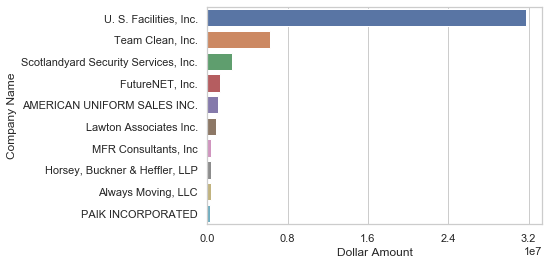

In [137]:
sns.set(style="whitegrid")
ax = sns.barplot(x="TOTAL_AMT", y="original_name", data=Top10_incity_payment)
ax.set(xlabel='Dollar Amount', ylabel='Company Name')
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
plt.show()

In [140]:
cert_types = incity[['original_name', 'certification_type']]

In [143]:
cert_types.groupby('certification_type').size().to_frame('N')

,N
certification_type,
MBE,22
MWBE,15
WBE,18


In [150]:
incity.groupby('certification_type')['TOTAL_AMT'].sum().to_frame('AMT')

,AMT
certification_type,
MBE,37794402.00
MWBE,7886693.81
WBE,808217.36


In [152]:
inMSA = data.loc[data['in_philly_msa'] == True]

In [154]:
inMSA_outcity = inMSA.loc[inMSA['local'] == False]

In [155]:
len(inMSA_outcity)

46

In [158]:
inMSA_outcity.groupby('certification_type').size().to_frame('N')

,N
certification_type,
MBE,18
MWBE,5
WBE,23


In [159]:
inMSA_outcity.groupby('certification_type')['TOTAL_AMT'].sum().to_frame('AMT')

,AMT
certification_type,
MBE,1583153.95
MWBE,273566.19
WBE,1518289.99
